In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


In [155]:
class Activation:

  def __init__(self, actv):
    self.actv = actv

  def activation_f(self, x, a = None):

    if self.actv == 'sigmoid':
       return 1 / (1 + np.exp(-x))

    elif self.actv == 'tanh':
       return np.tanh(x)

    elif self.actv == 'ReLU':
       return np.maximum(0, x)

    elif self.actv == 'PReLU':
      if a is not None:
        return x if x >= 0 else a * x
      else:
        return np.maximum(x, 0)

In [126]:
def padding_f(image, padding):

  input_shape = image.shape

  padded_shape = (
        input_shape[0] + 2 * padding[0],
        input_shape[1] + 2 * padding[1],
        input_shape[2]
    )

  padded_input = np.zeros(padded_shape)

  padded_input[
      padding[0]:padding[0] + input_shape[0],
      padding[1]:padding[1] + input_shape[1],
      :
  ] = image

  return padded_input

In [211]:
def convolution(image, kernel, act_f, stride=(1, 1), padding=(0, 0)):
    W, H, C = image.shape
    w, h, _ = kernel.shape

    s = stride
    p = padding

    padded_img = padding_f(image, p)

    W_f = (W + 2 * p[0] - w) // s[0] + 1
    H_f = (H + 2 * p[1] - h) // s[1] + 1

    feature_map = np.zeros((W_f, H_f))

    for c in range(C):
      for i in range(W_f):
          for j in range(H_f):
            feature_map[i, j] += np.sum(np.multiply(kernel[:, :, c], padded_img[i * s[0]:i * s[0] + w, j * s[1]:j * s[1] + h, c]))

    function = Activation(act_f)
    feature_map = function.activation_f(feature_map)

    return feature_map


In [208]:
img = Image.open('logo.png')
img = img.convert('RGB')
img.save('photo.png')

(32, 32, 3)

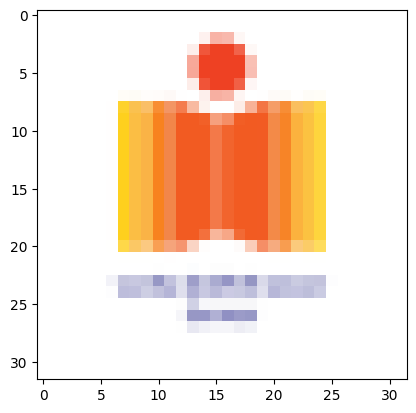

In [209]:
image = mpimg.imread('photo.png')
plt.imshow(image)
image.shape

[[[0.42457762 0.75712937 0.02868103]
  [0.76421989 0.59193509 0.35031952]
  [0.79098218 0.71879739 0.79591515]]

 [[0.13016672 0.36444966 0.9339794 ]
  [0.77991429 0.75218532 0.99019654]
  [0.89120093 0.69980263 0.69970748]]

 [[0.33353326 0.15512605 0.57270385]
  [0.00266644 0.15478651 0.50471174]
  [0.41442565 0.82817888 0.44757121]]]


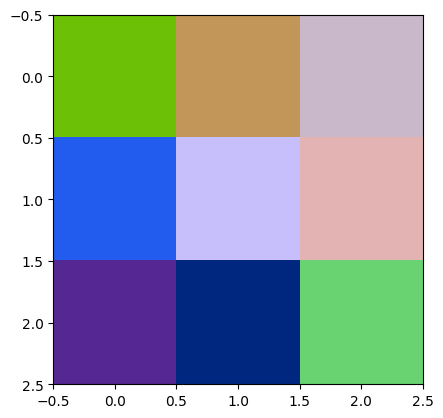

In [191]:
kernel = np.random.rand(3, 3, 3)
print(kernel)
plt.imshow(kernel)

(32, 32)


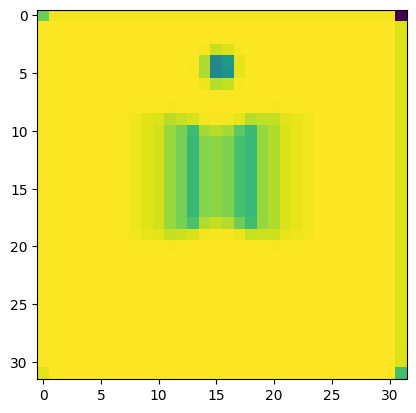

In [212]:
conv_img = convolution(image, kernel, act_f='sigmoid', stride=(1, 1), padding=(1, 1) )
plt.imshow(conv_img)
print(conv_img.shape)

In [216]:
def pooling(output, pool_size, pooling_function, stride):

  W, H  = output.shape

  w = pool_size[0]
  h = pool_size[1]

  s = stride

  W_f = np.ceil((W - w + 1)/s[0]).astype(int)
  H_f = np.ceil((H - h + 1)/s[1]).astype(int)

  pooled = np.zeros((W_f, H_f))


  for i in range(W_f):
    for j in range(H_f):

      if (pooling_function.lower() == 'max'):
        pooled[i, j] = np.max(output[i*s[0]:i*s[0]+w, j*s[1]:j*s[1]+h])

      if (pooling_function.lower() == 'avg'):
        pooled[i, j] = np.mean(output[i*s[0]:i*s[0]+w, j*s[1]:j*s[1]+h])

      if (pooling_function.lower() == 'min'):
        pooled[i, j] = np.min(output[i*s[0]:i*s[0]+w, j*s[1]:j*s[1]+h])

  return pooled


(32, 32)


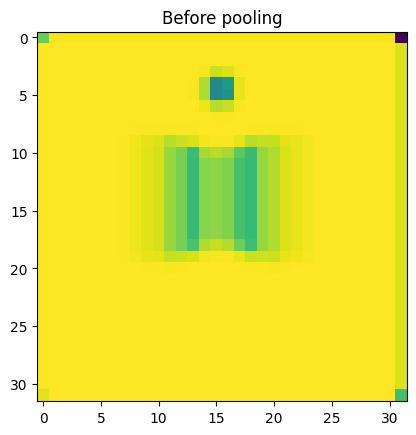

In [214]:
plt.imshow(conv_img)
plt.title("Before pooling")
print(conv_img.shape)

(15, 15)


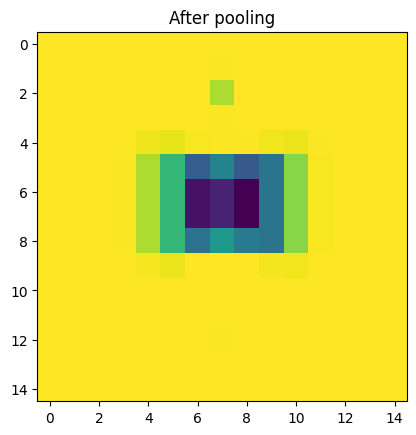

In [217]:
pooled_output = pooling(conv_img, (3, 3), 'max', (2, 2))
plt.imshow(pooled_output)
plt.title("After pooling")
print(pooled_output.shape)

In [245]:
def convolution_layer(image, num_kernels, kernel_shape, stride=(1, 1), padding =(0, 0), act_f = 'sigmoid'):
  if(image.ndim == 2):
    image = np.array(image)
    image = image.reshape((image.shape[0], image.shape[1], 1))

  output= []

  for i in range(num_kernels):
    kernel = np.random.random(kernel_shape)
    output.append(convolution(image, kernel, act_f, stride, padding))

  output = np.array(output)

  return output.transpose(1, 2, 0)

(32, 32, 3)

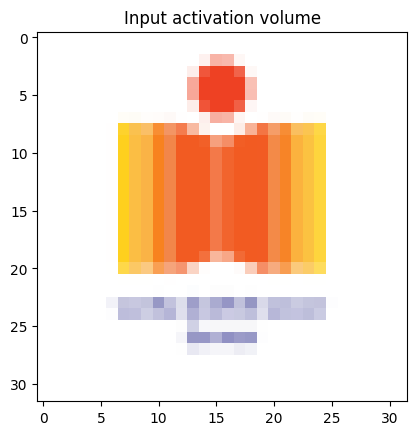

In [250]:
input = mpimg.imread('photo.png')
plt.imshow(input)
plt.title('Input activation volume')
input.shape

In [255]:
image = input
num_kernels = 10
kernel_shape = (3, 3, 3)
stride = (2,2)
padding = (0,0)
act_f = 'sigmoid'
conv_output = convolution_layer(image, num_kernels, kernel_shape, stride, padding, act_f)

In [256]:
print("The output has a shape of {} ".format(conv_output.shape))

The output has a shape of (15, 15, 10) 


(W-w+1)/stride = (32-3+1)/2 = 15

(H-h+1)/stride = (32-3+1)/2 =15

which matches with the height and width of the image

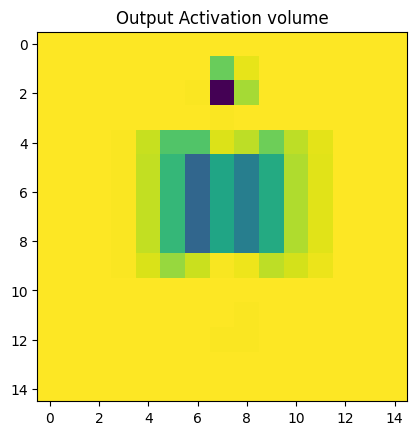

In [257]:
plt.title('Output Activation volume')
for i in range(num_kernels):
  plt.imshow(conv_output[:, :, i])

In [265]:
def pooling_layer(input, pool_size, pooling_function, stride):

  output = []
  for i in range(input.shape[2]):
    output.append(pooling(input[:, :, i], pool_size, pooling_function, stride))

  output = np.array(output)
  return output.transpose(1, 2, 0)


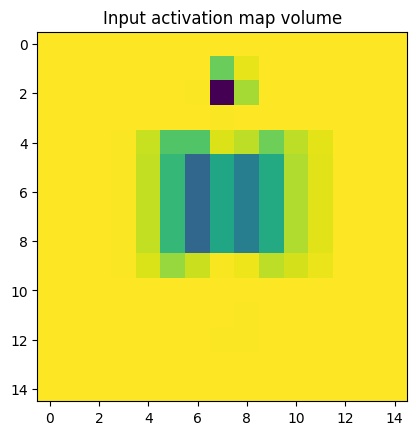

In [267]:
n = conv_output.shape[2]
plt.title('Input activation map volume')
for i in range(n):
  plt.imshow(conv_output[:, :, i])

In [266]:
output = pooling_layer(conv_output, (2, 2), 'max', (1,1))

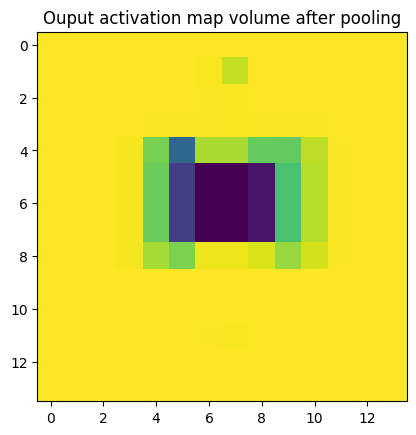

In [268]:
plt.title('Ouput activation map volume after pooling')
for i in range(n):
  plt.imshow(output[:, :, i])

In [269]:
def flattening(input, output_size):
    vec = np.ravel(input)
    w_matrix = np.random.random((output_size , len(vec)))
    output = w_matrix @ vec
    return output

In [270]:
def MLP(input, num_hidden, hidden_size, act_f, output_size):

  x = np.hstack((1, input))

  for i in range(num_hidden):
    w = np.random.rand(len(x), hidden_size[i])
    z = x @ w

    function = Activation(act_f)
    x = function.activation_f(z)

    x = np.hstack((1, x))

  w = np.random.rand(len(x), output_size)
  output_without_softmax = x @ w
  output_with_softmax = np.exp(output_without_softmax) / np.sum(np.exp(output_without_softmax))

  return output_without_softmax, output_with_softmax


In [273]:
def feed_forward(input):

  output1 = convolution_layer(input, 16, (3, 3,3), act_f = 'sigmoid')
  output2 = pooling_layer(output1, (2,2), 'max', (2,2))
  output3 = convolution_layer(output2, 8, (3, 3, 16), act_f = 'sigmoid') #C2 = 16
  output4 = pooling_layer(output3, (2,2), 'max', (2,2))
  output5 = flattening(output4, 32)
  output, output_softmax = MLP(output5, 1, [64], 'sigmoid', 10)

  print("The final output is: {}".format(output))
  print("The final output with probabilities is: {}".format(output_softmax))

  return output1.shape, output2.shape, output3.shape, output4.shape, output5.shape



In [274]:
input = mpimg.imread('photo.png')
feed_forward(input)

(30, 30, 16) (15, 15, 16) (13, 13, 8) (6, 6, 8) (32,)
The final output is: [34.69175893 34.39757643 29.20422852 32.04925251 31.73430968 31.55439446
 36.09718542 34.28580132 33.87440744 30.17966442]
The final output with probabilities is: [0.14060766 0.10477246 0.00058184 0.01000882 0.00730475 0.00610195
 0.57329471 0.09369228 0.0620923  0.00154323]


In [275]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
batch_size = 1

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
datalist = list(dataloader)

100%|██████████| 170498071/170498071 [00:01<00:00, 105320549.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [276]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
cifar_data = unpickle('data_batch_1')
data = cifar_data[b'data']
labels = cifar_data[b'labels']

In [ ]:
class_images = {}

for i in range(10):
    class_index = np.where(np.array(labels) == i)[0][0]
    image = data[class_index].reshape(3, 32, 32).transpose(1, 2, 0)
    class_images[i] = image

In [ ]:
for i in range(len(class_images)):
  feed_forward(class_images[i])

All the output vectors are approximatley the same irrespective of class of the image. This maybe because of the randomly initialised weights

In [279]:
def bottleneck(input):
  output1 = convolution_layer(input, 16, (3, 3,3), act_f = 'sigmoid')
  output2 = pooling_layer(output1, (2,2), 'max', (2,2))
  output3 = convolution_layer(output2, 8, (3, 3, 16), act_f = 'sigmoid') #C2 = 16
  output4 = pooling_layer(output3, (2,2), 'max', (2,2))
  output5 = flattening(output4, 32)
  return output5


In [ ]:
class_images = {}
images_per_class = 3

for i in range(10):
    class_indices = np.where(np.array(labels) == i)[0][:images_per_class]
    class_images[i] = data[class_indices].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
X = np.zeros((30,32))
k = 0
for i in range(10):
  class_i = class_images[i]
  for j in range(3):
    image = class_i[j]
    X[k] = bottleneck(image)
    k = k+1


In [ ]:
Y = np.zeros(30)
for k in range (30):
  for i in range(10):
    Y[k:k+3] = i
    k=k+3

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


We can see in the plot that the points are arbitrarily scattared irrespective of the class.Randomly initialized network doesn't distinguish the images of different classes well because of randomisation. Hence, it is non-discriminable.